In [1]:
from read_ggp_run import *
from cells_simulation import *
from matplotlib.lines import Line2D
from ipynb.fs.defs.plot_predictions import *


In [2]:
params_config = {'mean_lambda': 'bound',
                    'gamma_lambda': 'bound',
                    'var_lambda': 'bound',
                    'mean_q': 'bound',
                    'gamma_q': 'bound',
                    'var_q':'bound',
                    'beta':'bound',
                    'var_x':'bound',
                    'var_g':'bound',
                    'var_dx':'bound',
                    'var_dg':'free'} 


In [3]:
def param_estimate_noise_levels(directory, sample, param_range,  params_config,
                                exclude_param = ["var_dg", "var_dx", "var_g"],
                                labels= ["1.", "2.", "3."],
                                colors = ["cornflowerblue", "mediumblue", "darkblue"], 
                                max_xspan = 0.1):

    ### COLLECT ###
    params_reldev = dict.fromkeys(params_config.keys(), [])
    for i, p in enumerate(param_range.flatten()):
    # for i in [0]:
        for parameter in params_reldev.keys():
            directory_i = directory.format(i)
            sample_i = sample.format(i)
            filebase = default_filebase(directory_i, sample_i) # default

            _, minimization_final_file = get_minimization_file(filebase, params_config)
            params_final = read_params_config(minimization_final_file)

            init = get_params_config(params_final, parameter)["init"].values[0]
            final = get_params_config(params_final, parameter)["final"].values[0]
            reldev = (final-init)/init
            # reldev = final
            params_reldev[parameter] = params_reldev[parameter] + [reldev]

    for parameter in params_reldev.keys():
        params_reldev[parameter]  = np.reshape(params_reldev[parameter], np.shape(param_range))    

    ### PLOT ###
    fig, ax = plt.subplots(figsize=(17, 5))
    xticks = [param for i, param in  enumerate(params_reldev.keys()) if param not in exclude_param]
    subticks = np.linspace(-max_xspan, max_xspan, np.shape(param_range)[0])
    

    for j, xlabel in enumerate(xticks):
        x = np.transpose(j + np.array([subticks]*np.shape(param_range)[1]))
        # print(xlabel, x, params_reldev[xlabel])
        for col in np.arange(np.shape(param_range)[0]):
            ax.scatter(x[col], params_reldev[xlabel][col], c=colors[col])

    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks, rotation=45)

    legend_elements = [Line2D([0],[0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) \
                        for l,c in zip(labels, colors)]

    ax.axhline(0, color='grey', ls='--')
    ax.legend(handles=legend_elements)
    ax.set_ylim([-0.3, 0.3])
    ax.set_title(r"relative deviation $ (\Theta_{inferred} -\Theta_{true} )/ \Theta_{true} $")
    plt.show()

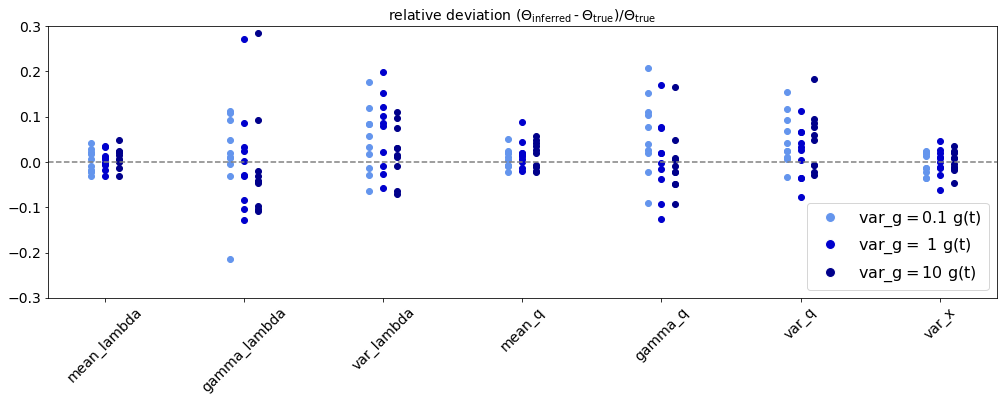

In [4]:
labels = [r'var_g$=0.1\ g(t)$', r'var_g$=\ 1\ g(t)$', r'var_g$=10\ g(t)$']

directory = '../data/scaled_noise_set_n250_var_g_sizer/'
sample = 'scaled_noise_set_n250_var_g_sizer_{:d}'
directory+=sample

param_range = np.transpose([np.geomspace(0.1, 10, 3) for i in range(10)])
param_estimate_noise_levels(directory, sample, param_range, params_config,
                                exclude_param = ["var_dg", "beta", "var_g", "var_dx"],
                                labels= labels)
                                

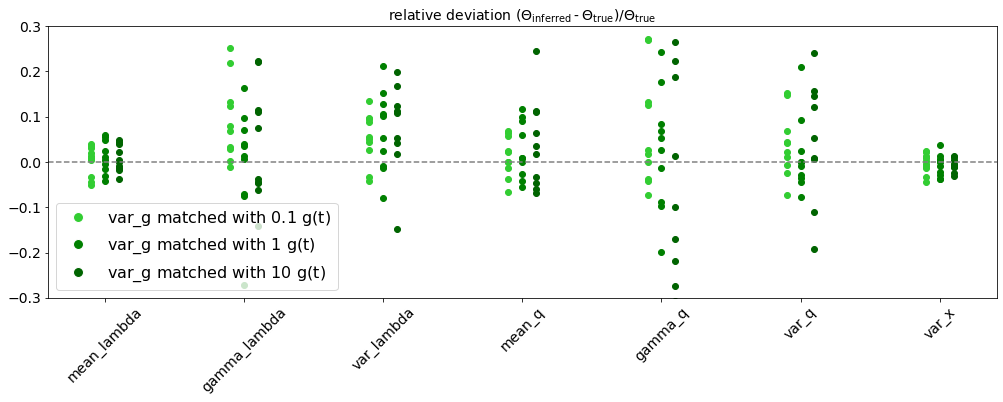

In [5]:
labels = [r'var_g matched with $ 0.1\ g(t)$', r'var_g matched with $ 1\ g(t)$', r'var_g matched with $ 10\ g(t)$']

directory = '../data/match_scaled_noise250_var_g_sizer/'
sample = 'match_scaled_noise250_var_g_sizer_{:d}'
directory+=sample

param_range = np.transpose([[363.76655668, 3674.76841188, 35993.84777024] for i in range(10)])
param_estimate_noise_levels(directory, sample, param_range, params_config,
                                exclude_param = ["var_dg", "beta", "var_g", "var_dx"],
                                labels= labels, 
                                colors=["limegreen", "green", "darkgreen"])
                                

In [6]:
def plot_var_predictions(directory_templ, sample_templ, no=5, x="var_x", xlabel="x"):
    fig, ax = plt.subplots() 
    ax.ticklabel_format(style='sci', scilimits=(-1,2), useOffset=False)

    ax2 = ax.twinx()
    ax2.ticklabel_format(style='sci', scilimits=(-1,2), useOffset=False)

    init = []
    final = []
    final_second = []
    var1 = []
    var2 = []
    gfp_t = []
    ll_t = []
    for i in range(no):
        directory = directory_templ.format(i)
        sample = sample_templ.format(i)
        filebase = default_filebase(directory, sample) # default

        dat_file = get_data_file(directory, sample)
        prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

        indata = pd.read_csv(dat_file)
        prediction = pd.read_csv(prediction_file, skiprows=13)

        params_config = read_params_config(prediction_file)
        final.append(get_params_config(params_config, x)["final"].values[0])

        if x == "var_g":
            final_second.append(get_params_config(params_config, "var_x")["final"].values[0])
        else:
            final_second.append(get_params_config(params_config, "var_g")["final"].values[0])

        cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
        cells_noise = df2cells(indata, time="time_min", log_length="log_length_noise", gfp="gfp_noise", parent_id=None)

        for cell in cells_true:
            gfp_t += cell.gfp
            ll_t += cell.log_length
        cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)

        var_log_length_dev, var_gfp_dev = var_predictions(cells_prediction, cells_true)
        _, var_gfp_dev_init = var_predictions(cells_noise, cells_true)
        init.append(var_gfp_dev_init)

        var1.append(var_log_length_dev)
        var2.append(var_gfp_dev)

    c1 = "darkred"
    c2 = "tab:blue"

    sq_init = np.sqrt(np.array(init))
    sq_final = np.sqrt(np.array(final))
    sq_final_second = np.sqrt(np.array(final_second))
    sq_var1 = np.sqrt(np.array(var1))
    sq_var2 = np.sqrt(np.array(var2))


    if x == "var_g":
        ax.scatter(sq_init, sq_var2, color=c1, 
                    label=r"std gfp (prediction - true) | $\langle g(t) \rangle_t =${:.0f}".format(np.mean(gfp_t)))
        

        # ax.scatter(init, final, color='grey', label="inferred")
        ax.plot(np.linspace(0,sq_init[-1],10), 
                np.linspace(0,sq_init[-1],10), color=c1, ls="--")
        ax2.scatter(sq_init, sq_var1, color=c2, 
                    label=r"std log length (prediction - true)| $\langle x(t) \rangle_t =${:.3f}".format(np.mean(ll_t)))

        ax.tick_params(axis='y', colors=c1)
        ax2.tick_params(axis='y', colors=c2)

        ax2.set_ylabel(r"log length")
        ax.set_ylabel(r"gfp")

        ax.yaxis.label.set_color(c1)
        ax2.yaxis.label.set_color(c2)

        ax.set_ylim([0,np.max(sq_var2)*1.1])
        ax2.set_ylim([0,np.max(sq_var1)*1.1])

    else:
        ax.scatter(sq_init, sq_var1, color=c2, 
                    label=r"std log length (prediction - true)| $\langle x(t) \rangle_t =${:.3f}".format(np.mean(ll_t)))

        # ax.scatter(init, final, color='grey', label="inferred")
        ax.plot(np.linspace(0,sq_init[-1],10), 
                np.linspace(0,sq_init[-1],10), color=c2, ls="--")
        ax2.scatter(sq_init, sq_var2, color=c1, 
                    label=r"std gfp (prediction - true) | $\langle g(t) \rangle_t =${:.0f}".format(np.mean(gfp_t)))
        
        ax.tick_params(axis='y', colors=c2)
        ax2.tick_params(axis='y', colors=c1)

        ax.set_ylabel(r"log length")
        ax2.set_ylabel(r"gfp")

        ax.yaxis.label.set_color(c2)
        ax2.yaxis.label.set_color(c1)

        ax.set_ylim([0,np.max(sq_var1)*1.1])
        ax2.set_ylim([0,np.max(sq_var2)*1.1])
    ax.set_xlabel(xlabel)

    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
    plt.show()

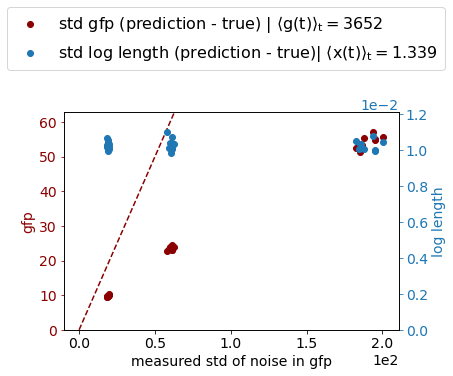

In [7]:

directory = '../data/scaled_noise_set_n250_var_g_sizer/'
sample = 'scaled_noise_set_n250_var_g_sizer_{:d}'
directory+=sample

var_gs = plot_var_predictions(directory, sample, no=30, x="var_g", xlabel=r"measured std of noise in gfp" )


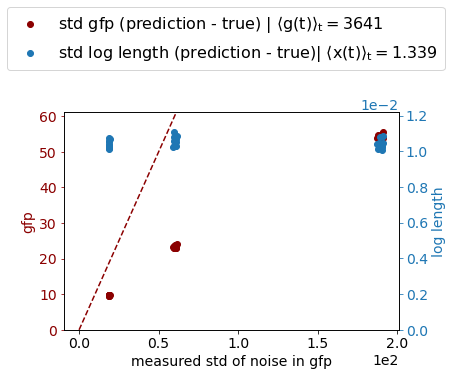

In [8]:
directory = '../data/match_scaled_noise250_var_g_sizer/'
sample = 'match_scaled_noise250_var_g_sizer_{:d}'
directory+=sample
var_gs = plot_var_predictions(directory, sample, no=30, x="var_g", xlabel=r"measured std of noise in gfp" )
